# Reinforcement Learning

### Each day (observation) is going to be a different step. 
I will use 14 stocks from the portfolio_creation notebook since are the ones that have momentum bigger than 0.5. 
Remember we can buy (0), sell (1) or hold (2) (3 possible actions). The combinations of those possible actions are the amount of stocks to the power of the possible actions, straightforward 14³, that is 2744 different actions. For example, we can buy all of our shares, or sell all but one, etc.<br>
As in the portfolio creation notebook we are going to have a 1000000 budget and we need to allocate it.
Min Max logic

In [1]:
import pandas as pd
import numpy as np
from collections import deque
#Be able to plot data
import matplotlib.pyplot as plt
#to save pytorch model
import torch
from env import Enviroment
import os

In [2]:
path = "RL_data/"
codes = os.listdir(path)
all_df = pd.DataFrame()
for nombre in codes:
    try:
        df = pd.read_csv(path + nombre)
        df.set_index('Date', inplace = True)
        df.rename(columns = {'Adj Close': nombre}, inplace = True)
        all_df = all_df.join(df[[nombre]], how='outer')
    except:
        print("Warning: Stock: " + nombre + " Cannot be find with that name")
        pass
all_df.to_csv('rl_data.csv')

In [2]:
init_money = 1000000
num_stocks = 3
action_space = num_stocks ** 3
state_space = (num_stocks * 2) + 1

In [3]:
all_df = pd.read_csv('rl_data.csv', index_col = "Date")[["LOW.csv", "NVDA.csv", "JPM.csv"]]
all_df.head()

,LOW.csv,NVDA.csv,JPM.csv
Date,,,
2014-01-02,43.691132,14.996614,47.986519
2014-01-03,43.258118,14.816958,48.357494
2014-01-06,42.648346,15.015525,48.637775
2014-01-07,42.754391,15.261368,48.077198
2014-01-08,42.904621,15.469398,48.530605


In [4]:
portfolio_train = all_df.iloc[:-150]
portfolio_test = all_df.iloc[-150:]

In [5]:
env = Enviroment(portfolio_train, init_money)

### State space
We have the first 14 values representing the amount of stocks we have when the enviroment has been reset, the next 14 values represents the rounded adjusted closing price and finally we have the amount of cash we have

In [10]:
portfolio_train.shape

(1612, 3)

In [6]:
info = env.reset()
info

[0, 0, 0, 44.0, 15.0, 48.0, 1000000]

In [30]:
env = Enviroment(portfolio_test, init_money)
state = env.reset()                                               # get the current state
score = []                                                        # initialize the score
while True:
    action = np.random.choice(list(range(0, action_space)))       # select an action
    env_info = env.step(action)                                   # send the action to the environment
    next_state = env_info[0]                                         # get the next state
    reward = env_info[1]                                           # get the reward
    done = env_info[-1]                                           # see if episode has finished
    score.append(reward)                                          # update the score
    state = next_state                                            # roll over the state to next time step
    if done:                                                      # exit loop if episode finished
        break

In [5]:
from dqn import Agent

env = Enviroment(portfolio_train, init_money)
agent = Agent(state_size=state_space, action_size=action_space, seed=12)

def dqn(n_episodes=2000, max_t=1615, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #This store scores from each episodes
    scores = []
    #Check last 100 scores as said finished 
    scores_window = deque(maxlen=100)  
    #How epsilon starts, remeber should start big and gradually decay
    eps = eps_start
    #Iterate through number of episodes
    for i_episode in range(1, n_episodes+1):
        #start
        env_reset = env.reset()
        #state
        state = np.array(env_reset)
        #initialize score to 0
        score = 0
        #iterate through max number of trainings per episode
        for t in range(max_t):
            #return action 
            action = agent.act(state, eps)
            #take action
            env_reset = env.step(action)
            #store state produced by given action
            next_state = np.array(env_reset[0])
            #store reward
            reward = env_reset[1]
            #check if done
            done = env_reset[-1]
            #learn through sampling Replay Buffer
            agent.step(state, action, reward, next_state, done)
            #Set next_state as state
            state = next_state
            #Add to score the reward
            score += reward
            #if done break
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

Episode 50	Average Score: 3813170.90
Episode 100	Average Score: 4532693.64
Episode 150	Average Score: 4512107.33
Episode 200	Average Score: 4418264.87
Episode 250	Average Score: 5159425.95
Episode 300	Average Score: 3794416.61
Episode 350	Average Score: 3717476.26
Episode 400	Average Score: 3493230.23
Episode 450	Average Score: 1818821.54
Episode 500	Average Score: 2093540.58
Episode 550	Average Score: 5063459.25
Episode 600	Average Score: 9567470.04
Episode 650	Average Score: 7989103.75
Episode 700	Average Score: 5628884.30
Episode 750	Average Score: 4817914.81
Episode 800	Average Score: 4544916.67
Episode 850	Average Score: 4418744.95
Episode 900	Average Score: 4180034.62
Episode 950	Average Score: 4386381.42
Episode 1000	Average Score: 4902361.25
Episode 1050	Average Score: 5112625.43
Episode 1100	Average Score: 4010689.27
Episode 1150	Average Score: 7214003.08
Episode 1200	Average Score: 8404081.89
Episode 1250	Average Score: 6568159.71
Episode 1300	Average Score: 9225239.11
Episod

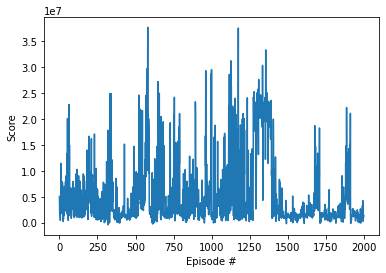

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [34]:
filename_to_load = 'checkpoint.pth'
final_eps = 0.05

agent = Agent(state_size=state_space, action_size=action_space, seed=12)
#load the saved model from previous training
agent.qnetwork_local.load_state_dict(torch.load(filename_to_load))

<All keys matched successfully>

In [43]:
env = Enviroment(portfolio_test, init_money)
env_info = env.reset()
state = np.array(env_info)          
score = 0                                         
while True:
    action = agent.act(state, eps=final_eps)      
    env_info = env.step(action)    
    next_state = np.array(env_info[0]) 
    reward = env_info[1]                  
    done = env_info[-1]                 
    score += reward                               
    state = next_state                            
    if done:
        print("Your final score is:")
        print(score)
        break

Your final score is:
-35950.0
